In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torch.utils.data import DataLoader, Dataset

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/path')

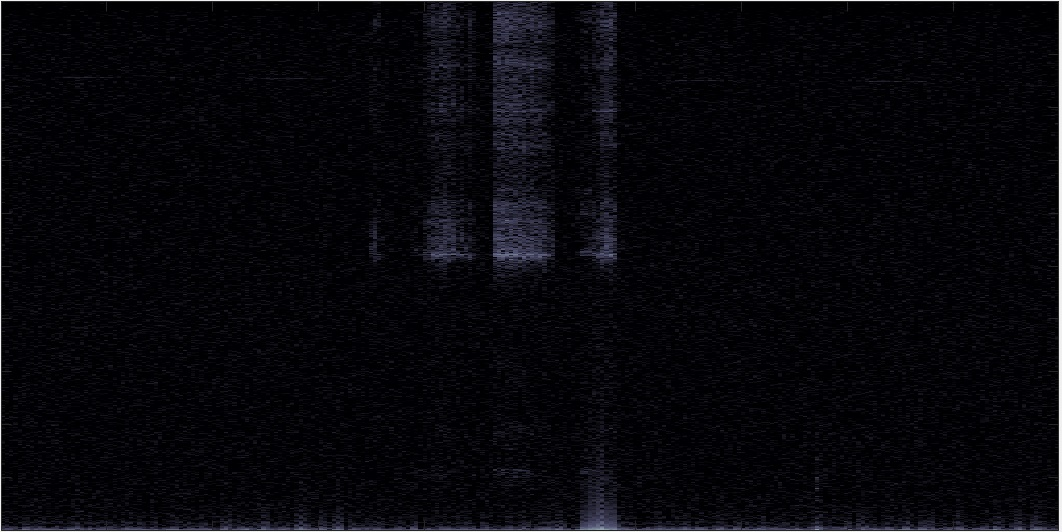

In [ ]:
image = cv2.imread(f'/content/path/1.jpg', cv2.IMREAD_COLOR)
cv2_imshow(image)

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, annotation_file):
      super().__init__()

      self.train_df = pd.read_csv(annotation_file)
      self.image_ids = self.train_df['filename'].unique()
    
    def __getitem__(self, index:int):
      image_id = self.image_ids[index]
      bboxes = self.train_df[self.train_df['filename'] == image_id]

      try:
        image = cv2.imread(f'/path/Image/{image_id}', cv2.IMREAD_UNCHANGED)
      except:
        image = cv2.imread(f'/path/Image/{image_id}', cv2.IMREAD_COLOR)

      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
      image /= 255.0

      boxes = bboxes[['xmin', 'ymin', 'xmax', 'ymax']].values
      area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
      
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
      area = torch.as_tensor(area, dtype=torch.float32)

      labels = torch.ones((bboxes.shape[0],), dtype=torch.int64)
      iscrowd = torch.zeros((bboxes.shape[0],), dtype=torch.int64)

      target = {}
      target['boxes'] = boxes
      target['labels'] = labels
      target['image_id'] = torch.tensor([index])
      target['area'] = area
      target['iscrowd'] = iscrowd

      image = torchvision.transforms.ToTensor()(image)
      return image, target

    def __len__(self) -> int:
      return self.image_ids.shape[0]

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# load the train dataset
def create_dataset(dictionary, filename):
  downloaded = drive.CreateFile(dictionary) 
  downloaded.GetContentFile(filename)  
  dataframe = pd.read_csv(filename)
  return dataframe

In [ ]:
label_dataset = create_dataset({'id' : 'code'}, 'train_labels.csv')

In [ ]:
label_dataset.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1.jpg,1062,532,sand,422,6,477,260
1,1.jpg,1062,532,sand,493,7,556,263
2,1.jpg,1062,532,sand,581,4,622,266
3,10.png,1059,531,sand,6,2,217,267
4,10.png,1059,531,sand,669,4,849,277


In [ ]:
# Initialize Dataset
train_dataset = TrainDataset('train_labels.csv')

def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
!pip install d2l==0.16.1
!pip install -U mxnet-cu101==1.7.0

     |████████████████████████████████| 81kB 5.9MB/s 
     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x64b60000 @  0x7f1334e4e615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 22kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


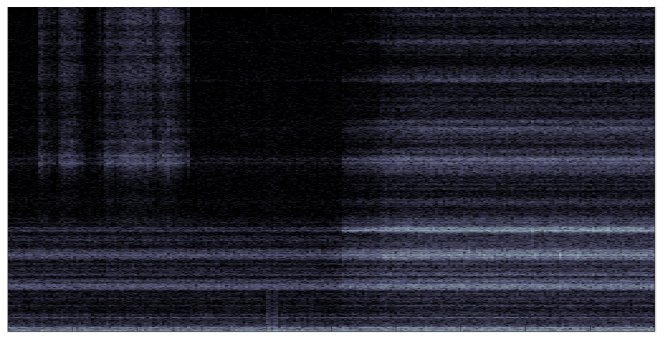

In [ ]:
from matplotlib import pyplot as plt

images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1, 2, 0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for box in boxes:
  cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (129,193,129), 20)

ax.set_axis_off()
ax.imshow(img)

In [ ]:
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import image, npx, np

npx.set_np()

In [ ]:
#@save
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (top-left x, top-left y, bottom-right x,
    # bottom-right y) format to matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

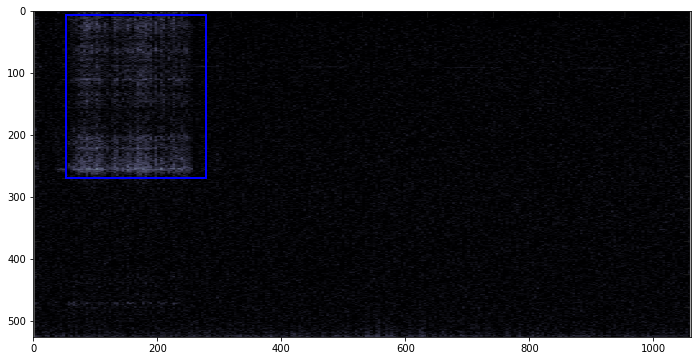

In [ ]:
images, targets = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

boxes = targets[0]['boxes'].cpu().numpy().astype(np.int32)
img = images[0].permute(1, 2, 0).cpu().numpy()
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for box in boxes:
  fig = d2l.plt.imshow(img)
  fig.axes.add_patch(bbox_to_rect(box, 'blue'))

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

In [ ]:
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 50

In [ ]:
if torch.cuda.is_available():
    model.cuda()

In [ ]:
itr = 1

for epoch in range(num_epochs):
  for images, target in train_data_loader:

    images = list(image.to(device) for image in images)
    targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

    loss_dict = model(images, targets)

    losses = sum(loss for loss in loss_dict.values())
    loss_value = losses.item()

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()

    if itr % 50 == 0:
      print(f'Iteration #{itr} loss: {loss_value}')

    itr += 1

    lr_scheduler.step()
  
  print(f'Epoch #{epoch} loss: {loss_value}')

torch.save(model.state_dict, 'model.pth')
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_value,
}, 'ckpth.pth')

Epoch #0 loss: 0.295025110244751
Iteration #50 loss: 0.2494201809167862
Epoch #1 loss: 0.20184235274791718
Epoch #2 loss: 0.26284608244895935
Iteration #100 loss: 0.2772811949253082
Epoch #3 loss: 0.28712451457977295
Epoch #4 loss: 0.2585941553115845
Iteration #150 loss: 0.2429429441690445
Epoch #5 loss: 0.22115133702754974
Epoch #6 loss: 0.2893286347389221
Iteration #200 loss: 0.2712804675102234
Epoch #7 loss: 0.27576854825019836
Epoch #8 loss: 0.24846626818180084
Iteration #250 loss: 0.294502854347229
Epoch #9 loss: 0.23936045169830322
Epoch #10 loss: 0.1977124959230423
Iteration #300 loss: 0.23999541997909546
Epoch #11 loss: 0.29948073625564575
Epoch #12 loss: 0.27868470549583435
Iteration #350 loss: 0.2223905473947525
Epoch #13 loss: 0.28393882513046265
Epoch #14 loss: 0.30805182456970215
Iteration #400 loss: 0.2853524386882782
Epoch #15 loss: 0.2857484519481659
Epoch #16 loss: 0.2877858877182007
Iteration #450 loss: 0.269599586725235
Epoch #17 loss: 0.1871565729379654
Epoch #18 lo

In [ ]:
class TestDataset(Dataset):
    def __init__(self, image_dir):
      super().__init__()

      self.image_ids = [fl for fl in list(sorted(os.listdir(image_dir))) if 'png' in fl]
      print(self.image_ids)
      self.image_dir = image_dir

    def __getitem__(self, index: int):
      image_id = self.image_ids[index]
      image = cv2.imread(f'{self.image_dir}{image_id}', cv2.IMREAD_UNCHANGED)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
      image /= 255.0
      
      image = torchvision.transforms.ToTensor()(image)

      return image

    def __len__(self) -> int:
      return len(self.image_ids)

In [ ]:
test_dataset = TestDataset('path')

test_data_loader = DataLoader(
    test_dataset
)

['1.png', '10.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']


In [ ]:
# pick one image from the test set
img = test_dataset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
images = next(iter(test_data_loader))
images = list(image.to(device) for image in images)
# put the model in evaluation mode
model.eval()
outputs = model(images)

idx = 0
sample = images[idx].permute(1,2,0).cpu().numpy()
boxes = outputs[idx]['boxes'].data.cpu().numpy()
scores = outputs[idx]['scores'].data.cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

for box in boxes:
  fig = d2l.plt.imshow(sample)
  fig.axes.add_patch(bbox_to_rect(box, 'blue'))